In [143]:
import xarray as xr
import pandas as pd
import pyproj
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add icedrift to the system path
sys.path.append('/Users/aless/Desktop/icedrift/src')

# Import necessary functions
from icedrift.analysis import compute_velocity, compute_absolute_dispersion, compute_along_across_components
from icedrift.interpolation import interpolate_buoy_track

# Define the directory containing the cleaned mosaic_dn2 buoy data
cirfa2022 = '../data/buoy_data/cirfa2022/cleaned_data/'

# List all CSV files in the directory
cirfa2022_files = [f for f in os.listdir(cirfa2022) if f.endswith('.csv')]

# Number of buoys to process
num_buoys = 14  # Adjust as needed

# Load each CSV into a dictionary with buoy IDs as keys
# Assuming buoy ID is part of the filename, e.g., cleaned_2020P162.csv
buoy_data = {}
for file in cirfa2022_files[:num_buoys]:
    buoy_id = os.path.splitext(file)[0]  # Removes the .csv extension
    file_path = os.path.join(cirfa2022
, file)
    df = pd.read_csv(file_path, parse_dates=['datetime'])  # Ensure 'datetime' is parsed correctly
    buoy_data[buoy_id] = df

print(f"Loaded data for {len(buoy_data)} buoys.")


Loaded data for 14 buoys.


In [144]:
# Interpolation Loop with Updated Frequency
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the DataFrame is sorted by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Check if 'datetime' is the index; if not, set it as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError(f"No 'datetime' column found in buoy data for buoy {buoy_id}")
    
    # Interpolate buoy track to hourly frequency with a maximum gap of 4 hours (240 minutes)
    interpolated_df = interpolate_buoy_track(
        df, 
        freq='1h',  # Changed from '1H' to '1h'
        maxgap_minutes=240
    ).loc[:, ['longitude', 'latitude']]
    
    buoy_data_interp[buoy_id] = interpolated_df

print("Interpolated buoy data to hourly frequency.")


Interpolated buoy data to hourly frequency.


In [145]:
# Initialize a dictionary to store daily resampled data with velocity
buoy_data_daily = {}

for buoy_id, df in buoy_data_interp.items():
    # Resample to daily frequency at 12:00 UTC
    daily = df.resample('24h', origin='start').asfreq().dropna()
    daily['buoy_id'] = buoy_id  # Add buoy identifier
    
    # Compute velocities
    daily = compute_velocity(daily, date_index=True, rotate_uv=False, method='c')
    
    # Optional: Compute along and across components
    # daily = compute_along_across_components(daily)
    
    buoy_data_daily[buoy_id] = daily

print("Velocity computation complete.")
print("Resampled buoy data to daily frequency at 12:00 UTC.")


Velocity computation complete.
Resampled buoy data to daily frequency at 12:00 UTC.


In [146]:
# Concatenate all buoy data into a single DataFrame
all_positions_daily = pd.concat(buoy_data_daily.values())

# Reset index to make 'datetime' a column
all_positions_daily.reset_index(inplace=True)

print("Combined all buoys into all_positions_daily.")
print(all_positions_daily.head())
print(all_positions_daily.columns)


Combined all buoys into all_positions_daily.
             datetime  longitude  latitude         buoy_id              x  \
0 2022-05-02 15:00:00   -7.86220  79.17333  CIRFA22_206771  710103.135941   
1 2022-05-03 15:00:00   -8.14182  79.05019  CIRFA22_206771  713589.982566   
2 2022-05-04 15:00:00   -8.32130  79.03557  CIRFA22_206771  711559.139212   
3 2022-05-05 15:00:00   -8.36163  79.05219  CIRFA22_206771  709802.590110   
4 2022-05-06 15:00:00   -8.47405  79.05196  CIRFA22_206771  707943.530003   

               y         u         v     speed  
0 -937638.245163       NaN       NaN       NaN  
1 -951858.802214  0.008426 -0.102619  0.102965  
2 -955370.836165 -0.021918 -0.014787  0.026440  
3 -954414.033033 -0.020924 -0.002629  0.021088  
4 -955825.096116 -0.045843 -0.049678  0.067598  
Index(['datetime', 'longitude', 'latitude', 'buoy_id', 'x', 'y', 'u', 'v',
       'speed'],
      dtype='object')


In [147]:
# Define the SIC extraction function (as provided)
def sic_along_track(position_data, sic_ds):
    """
    Uses xarray advanced interpolation to get along-track SIC via nearest neighbors.
    
    Parameters:
    - position_data: DataFrame with 'datetime', 'longitude', 'latitude'
    - sic_ds: xarray Dataset with 'sea_ice_concentration'
    
    Returns:
    - pandas Series with SIC values aligned to position_data index
    """
    # Define coordinate reference systems
    crs_wgs84 = pyproj.CRS('EPSG:4326')  # WGS 84
    crs_stere = pyproj.CRS(
        '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 '
        '+k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 '
        '+units=m +no_defs'
    )
    transformer = pyproj.Transformer.from_crs(crs_wgs84, crs_stere, always_xy=True)
    
    # Initialize SIC series
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    for date, group in position_data.groupby(position_data['datetime'].dt.date):
        try:
            # Transform coordinates to stereographic projection
            x_stere, y_stere = transformer.transform(group['longitude'].values, group['latitude'].values)
            
            # Create DataArrays for interpolation
            x = xr.DataArray(x_stere, dims="points")
            y = xr.DataArray(y_stere, dims="points")
            
            # Select SIC data for the current date
            sic_daily = sic_ds.sel(time=date.strftime('%Y-%m-%d'))
            
            # Perform nearest neighbor interpolation
            sic_values = sic_daily['sea_ice_concentration'].interp(
                x=x,
                y=y,
                method='nearest'
            ).values
            
            # Assign SIC values to the corresponding positions
            sic.loc[group.index] = np.round(sic_values, 3)
        except KeyError:
            # Handle dates not present in SIC data
            sic.loc[group.index] = np.nan
    
    # Replace SIC values greater than 100 with NaN
    sic[sic > 100] = np.nan
    return sic

# Load SIC data
sic_file = '../NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2022.nc'
sic_data = xr.open_dataset(sic_file)

# Reformat NSIDC data for convenience with interpolation -- rename coordinates and dimensions
ds = xr.Dataset({
    'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)
},
coords={
    'time': ('time', pd.to_datetime(sic_data.time.data)),
    'x': ('x', sic_data['xgrid'].data),
    'y': ('y', sic_data['ygrid'].data)
})

print("Loaded and reformatted SIC data.")

# Extract SIC values and add to all_positions_daily
all_positions_daily['sea_ice_concentration'] = sic_along_track(all_positions_daily, ds)

# Verify the column exists
print("Columns in all_positions_daily after SIC extraction:")
print(all_positions_daily.columns)

# Interpolate missing 'speed' values
all_positions_daily['speed'] = all_positions_daily['speed'].interpolate(method='linear')

# Forward fill any remaining NaNs
all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')

# Check the total number of NaNs in the 'speed' column
total_speed_nans = all_positions_daily['speed'].isna().sum()
print(f"Total NaN values in 'speed': {total_speed_nans}")

# Identify datetime groups where all 'speed' values are NaN
speed_nan_groups = all_positions_daily.groupby('datetime')['speed'].apply(lambda x: x.isna().all())
nan_dates = speed_nan_groups[speed_nan_groups].index.tolist()

print(f"Dates with all 'speed' values as NaN: {nan_dates}")

# Display rows where 'speed' is NaN
nan_speed_rows = all_positions_daily[all_positions_daily['speed'].isna()]
print("Rows with NaN 'speed' values:")
print(nan_speed_rows)


Loaded and reformatted SIC data.
Columns in all_positions_daily after SIC extraction:
Index(['datetime', 'longitude', 'latitude', 'buoy_id', 'x', 'y', 'u', 'v',
       'speed', 'sea_ice_concentration'],
      dtype='object')
Total NaN values in 'speed': 0
Dates with all 'speed' values as NaN: []
Rows with NaN 'speed' values:
Empty DataFrame
Columns: [datetime, longitude, latitude, buoy_id, x, y, u, v, speed, sea_ice_concentration]
Index: []


/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_40317/1395756394.py:81: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')


In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Calculate drift speed statistics using the correct 'speed' column
drift_speed_stats = all_positions_daily.groupby('datetime').agg(
    median_speed=('speed', 'median'),
    IQR_lower_speed=('speed', lambda x: x.quantile(0.25)),
    IQR_upper_speed=('speed', lambda x: x.quantile(0.75))
).reset_index()

# Calculate sea ice concentration statistics
sic_stats = all_positions_daily.groupby('datetime').agg(
    median_sic=('sea_ice_concentration', 'median'),
    IQR_lower_sic=('sea_ice_concentration', lambda x: x.quantile(0.25)),
    IQR_upper_sic=('sea_ice_concentration', lambda x: x.quantile(0.75))
).reset_index()


print("Statistical calculations complete.")
print(drift_speed_stats.head())
print(sic_stats.head())
# Check the date range of the SIC dataset

print("SIC Data Time Range:")
print(ds['time'].min().values, ds['time'].max().values)
# Inspect the SIC dataset
print(ds['sea_ice_concentration'])

# Check attributes for more details
print(ds['sea_ice_concentration'].attrs)



Statistical calculations complete.
             datetime  median_speed  IQR_lower_speed  IQR_upper_speed
0 2022-04-24 21:00:00      0.316440         0.316440         0.316440
1 2022-04-25 18:00:00      0.203122         0.203122         0.203122
2 2022-04-25 21:00:00      0.447332         0.447332         0.447332
3 2022-04-26 12:00:00      0.141610         0.141610         0.141610
4 2022-04-26 14:00:00      0.088187         0.088187         0.088187
             datetime  median_sic  IQR_lower_sic  IQR_upper_sic
0 2022-04-24 21:00:00        0.97           0.97           0.97
1 2022-04-25 18:00:00        1.00           1.00           1.00
2 2022-04-25 21:00:00        0.84           0.84           0.84
3 2022-04-26 12:00:00        1.00           1.00           1.00
4 2022-04-26 14:00:00        1.00           1.00           1.00
SIC Data Time Range:
2022-01-01T00:00:00.000000000 2022-12-31T00:00:00.000000000
<xarray.DataArray 'sea_ice_concentration' (time: 365, y: 448, x: 304)> Size: 199

In [149]:
# Interpolation Loop with Updated Frequency
buoy_data_interp = {}

for buoy_id, df in buoy_data.items():
    # Ensure the DataFrame is sorted by datetime
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Check if 'datetime' is the index; if not, set it as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError(f"No 'datetime' column found in buoy data for buoy {buoy_id}")
    
    # Interpolate buoy track to hourly frequency with a maximum gap of 4 hours (240 minutes)
    interpolated_df = interpolate_buoy_track(
        df, 
        freq='1h',  # Changed from '1H' to '1h'
        maxgap_minutes=240
    ).loc[:, ['longitude', 'latitude']]
    
    buoy_data_interp[buoy_id] = interpolated_df

print("Interpolated buoy data to hourly frequency.")



Interpolated buoy data to hourly frequency.


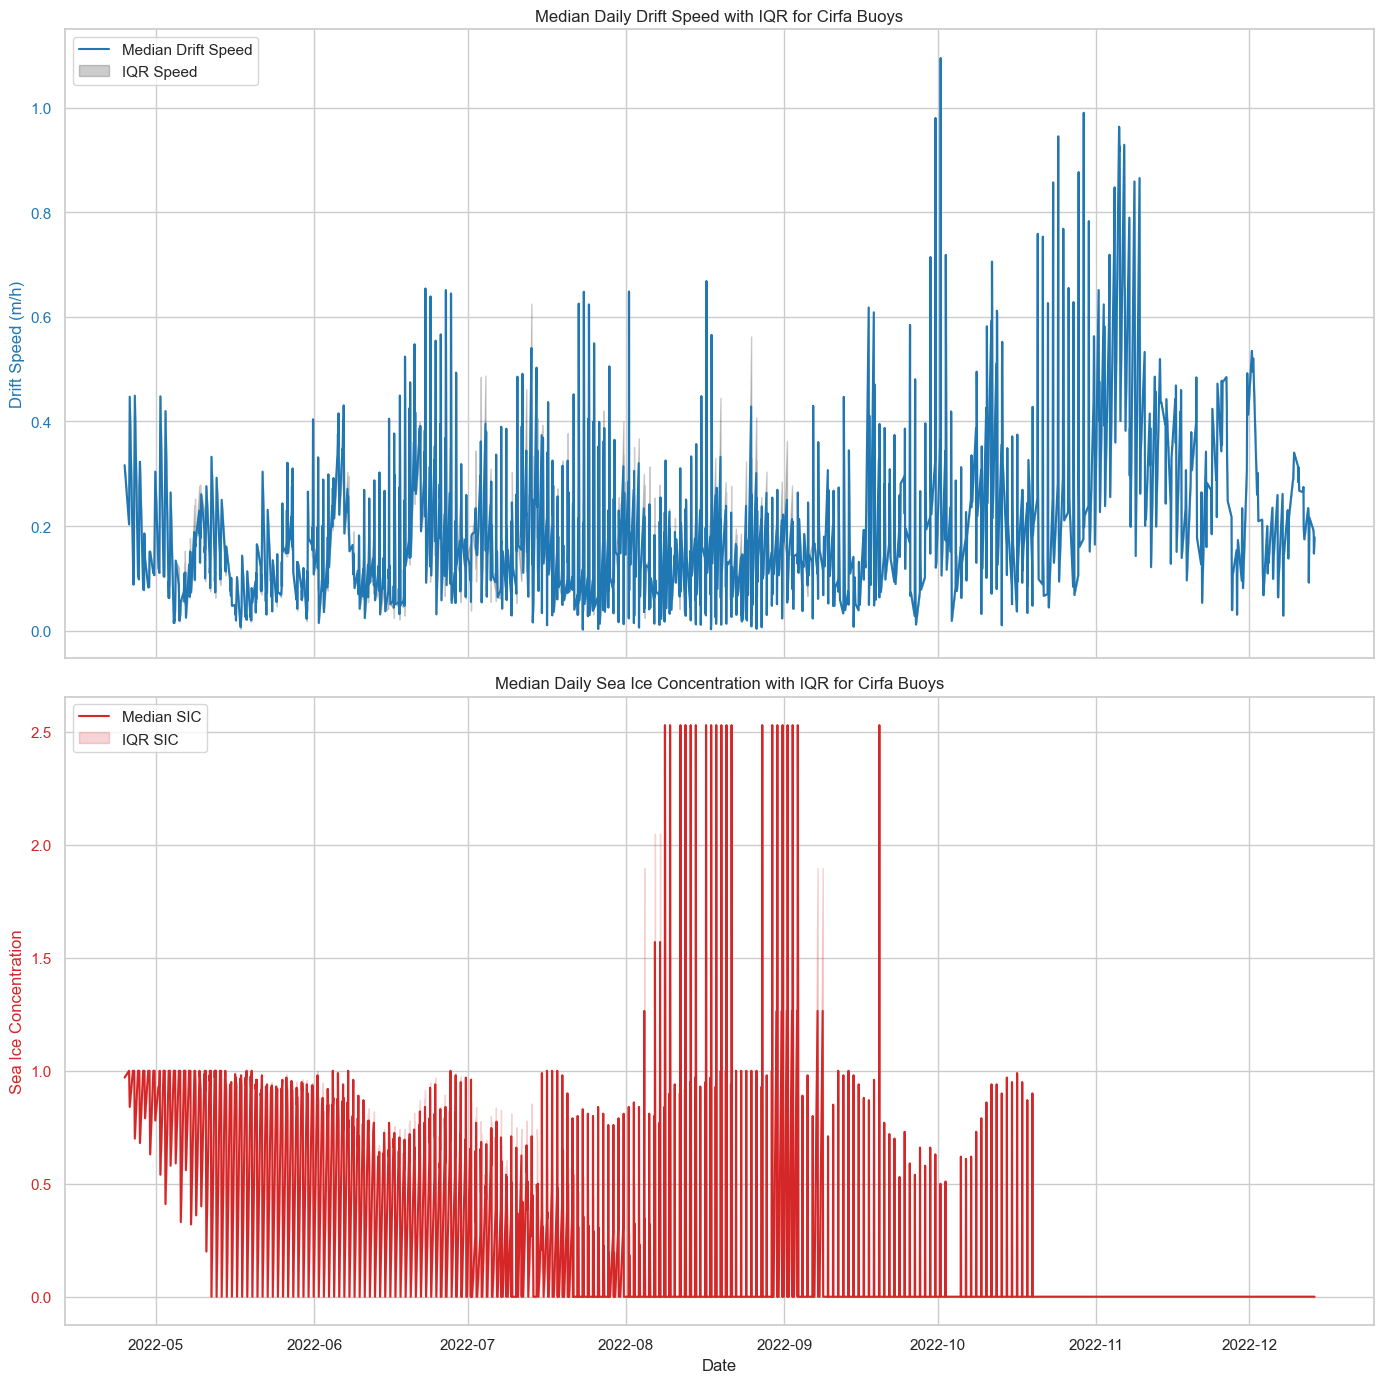

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot styl3
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)


# Plot Median Drift Speed
color = 'tab:blue'
ax1.set_ylabel('Drift Speed (m/h)', color=color)
ax1.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color=color)
ax1.fill_between(
    drift_speed_stats['datetime'],
    drift_speed_stats['IQR_lower_speed'],
    drift_speed_stats['IQR_upper_speed'],
    color= "black",
    alpha=0.2,
    label='IQR Speed'
)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_title('Median Daily Drift Speed with IQR for Cirfa Buoys')

# Plot Median Sea Ice Concentration
color = 'tab:red'
ax2.set_ylabel('Sea Ice Concentration', color=color)
ax2.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color=color)
ax2.fill_between(
    sic_stats['datetime'],
    sic_stats['IQR_lower_sic'],
    sic_stats['IQR_upper_sic'],
    color=color,
    alpha=0.2,
    label='IQR SIC'
)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title('Median Daily Sea Ice Concentration with IQR for Cirfa Buoys')

# Common X-axis label
plt.xlabel('Date')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


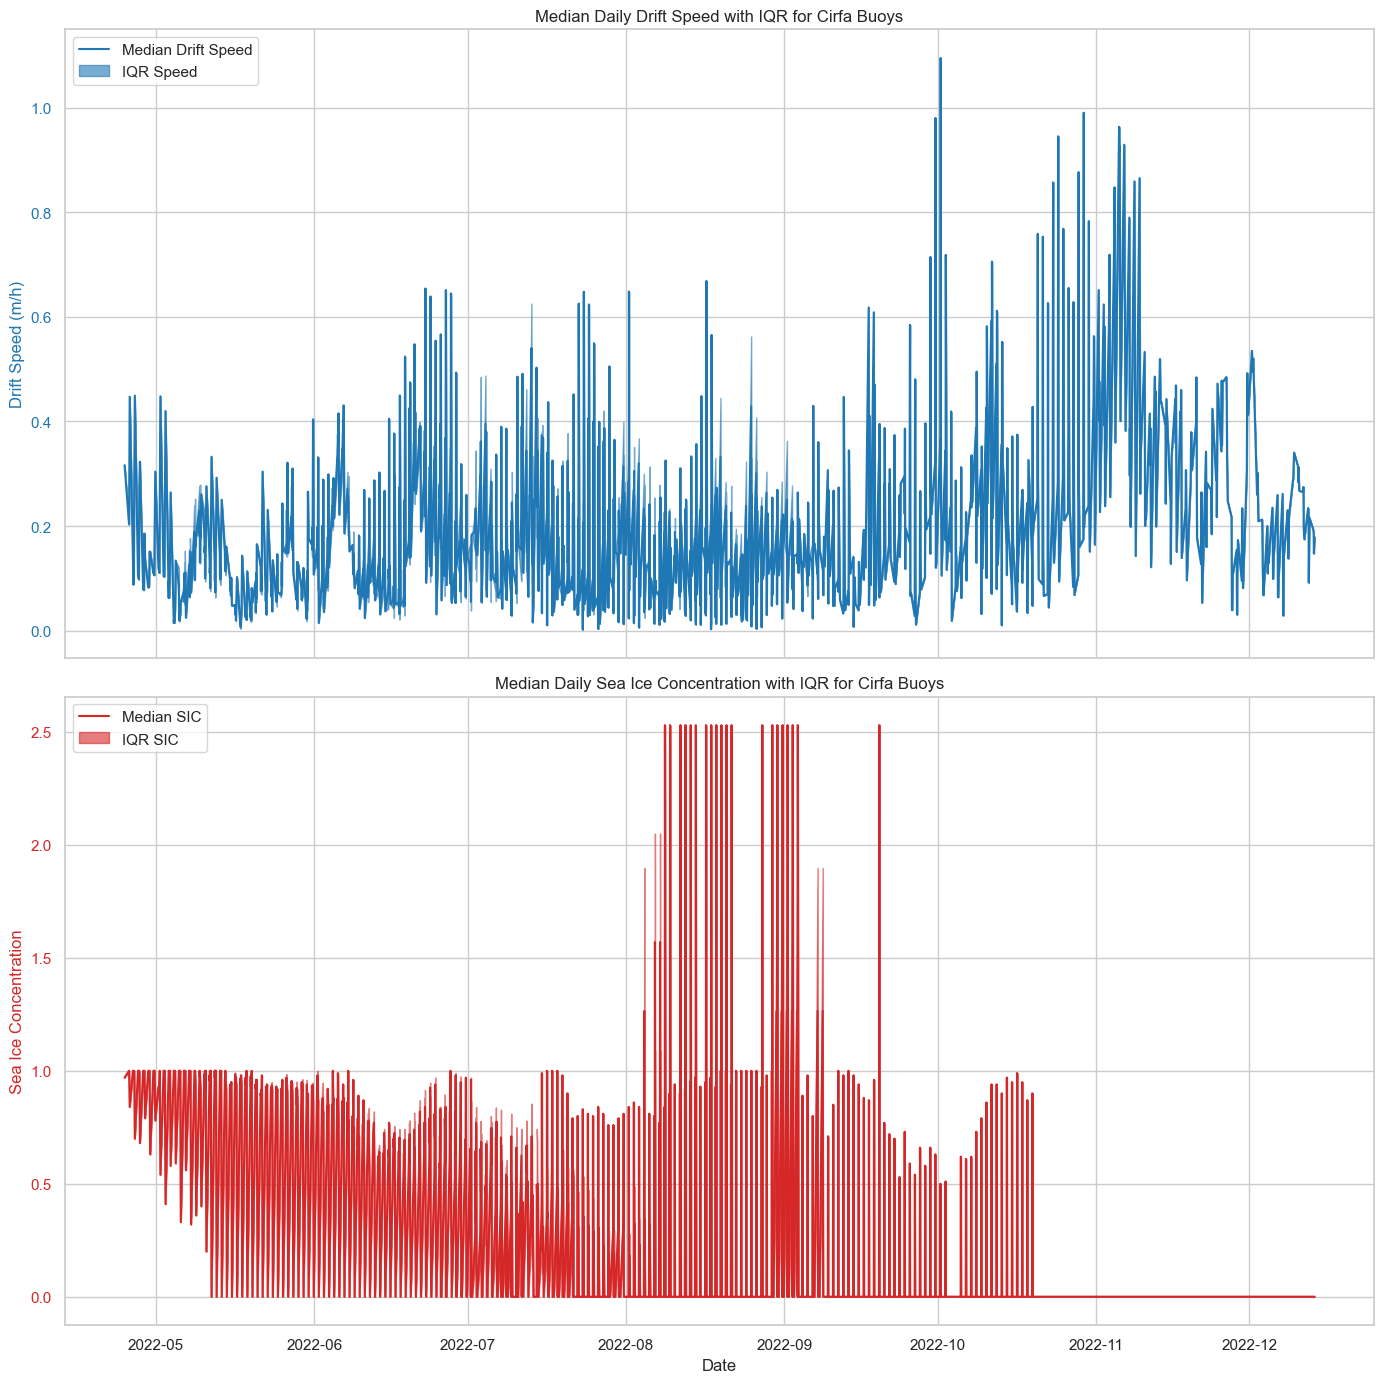

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set(style="whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

# Plot Median Drift Speed
color = 'tab:blue'
ax1.set_ylabel('Drift Speed (m/h)', color=color)
ax1.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color=color)
ax1.fill_between(
    drift_speed_stats['datetime'],
    drift_speed_stats['IQR_lower_speed'],
    drift_speed_stats['IQR_upper_speed'],
    color=color,
    alpha=0.6,
    label='IQR Speed'
)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_title('Median Daily Drift Speed with IQR for Cirfa Buoys')

# Plot Median Sea Ice Concentration
color = 'tab:red'
ax2.set_ylabel('Sea Ice Concentration', color=color)
ax2.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color=color)
ax2.fill_between(
    sic_stats['datetime'],
    sic_stats['IQR_lower_sic'],
    sic_stats['IQR_upper_sic'],
    color=color,
    alpha=0.6,
    label='IQR SIC'
)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title('Median Daily Sea Ice Concentration with IQR for Cirfa Buoys')

# Common X-axis label
plt.xlabel('Date')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
